In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import pudl.output.export

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 56

## High Level US Coal Operating Costs (\$/MWh) from EIA & FERC
 * 200-300 plants total.
 * Get EIA data by generator and FERC data by plant (PUDL and/or FERC Plant IDs)
 * Data years 2012-2017
 * FERC & EIA data mergeable by PUDL Plant ID (manually assigned)
 * Merged FERC data will be aggregated by PUDL Plant ID in cases where there are multiple owners reporting
 * Retain disaggregated FERC data in another Excel tab
 * Minimal data cleaning, relatively raw data output
 * 10 hours at \$75/hour Turn around: early next week.

In [4]:
pudl_out = pudl.output.pudltabl.PudlTabl(freq="MS", start_date="2012-01-01", end_date="2017-12-31")
steam_ferc1 = pudl_out.plants_steam_ferc1()
fuel_ferc1 = pudl_out.fuel_ferc1()

In [5]:
mcoe = pudl_out.mcoe()

/Users/christinagosnell/anaconda/envs/pudl/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
# For each plant record in the plants table, we need to be able to assign
# a fraction of heat content for that plant that came from a particlar fuel
# for filtering purposes. There are different ways that we can aggregate that
# information -- e.g. plant_id_pudl, plant_id_ferc1, (utility_id_ferc1, plant_name)
def coal_fraction(fuel_df, gb_cols=['plant_id_pudl']):
    """
    Calculate the fraction of overall heat content from coal
    per year and per gb_cols, which can be:
      - [plant_id_pudl]
      - [plant_id_ferc1]
      - [utility_id_ferc1, plant_name]
    
    Assumes fuel_df is a fuel_ferc1 dataframe.
    Cannot currently work for arbitrary fuel_type becuase not all plants
    have records for all fuel types.
    """
    gb_cols1 = ['report_year'] + gb_cols
    
    # Total heat content across all fuel types
    total_mmbtu = (
        fuel_df.groupby(gb_cols1).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        rename(columns={'fuel_consumed_mmbtu': 'total_mmbtu'})
    )
    
    # Same grouping... but also broken down by fuel type
    gb_cols2 = gb_cols1 + ['fuel_type_code_pudl']
    out_df = (
        fuel_df[fuel_df.fuel_type_code_pudl=='coal'].
        groupby(gb_cols2).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        merge(total_mmbtu, how='left', on=gb_cols1).
        assign(coal_fraction=lambda x: x['fuel_consumed_mmbtu'] / x['total_mmbtu']).
        rename(columns={'fuel_consumed_mmbtu': 'coal_mmbtu'}).
        drop(['fuel_type_code_pudl'], axis=1)
    )
    return out_df

In [7]:
ferc_cols_to_keep = ['report_year', 'utility_id_ferc1', 'utility_id_pudl',
                     'utility_name_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_name',
                     'avg_num_employees', 'installation_year','opex_allowances', 'opex_boiler',
                     'opex_coolants', 'opex_electric', 'opex_engineering',
                     'opex_misc_power', 'opex_misc_steam', 'opex_operations', 'opex_per_mwh',
                     'opex_plants', 'opex_production_total', 'opex_rents', 'opex_steam',
                     'opex_steam_other', 'opex_structures', 'opex_transfer']

In [8]:
# Calculate total heat content of fuel by plant & year
fuel_consumed_mmbtu = (
    fuel_ferc1.loc[fuel_ferc1.report_year>=2012,:].
    groupby(['report_year', 'plant_id_pudl']).
    agg({'fuel_consumed_mmbtu': sum}).
    reset_index()
)

coal_fraction_by_plant_name = coal_fraction(fuel_ferc1.loc[fuel_ferc1.report_year>=2012,:], ['utility_id_ferc1', 'plant_name'])

steam_agg_ferc1 = (
    # Only interested in 2012 and later
    steam_ferc1.loc[steam_ferc1.report_year>=2012,:].
    # This ensures we only include plants that use *some* coal
    merge(coal_fraction_by_plant_name, how='inner', on=['report_year', 'utility_id_ferc1', 'plant_name']).
    # Break out the non-fuel OpEx
    assign(opex_nonfuel=lambda x: x['opex_production_total'] - x['opex_fuel']).
    # Aggregate by plant_id_pudl
    groupby(['report_year','plant_id_pudl']).
    agg({'capacity_mw': sum,
         'net_generation_mwh': sum,
         'opex_fuel': sum,
         'opex_nonfuel': sum}).
    reset_index().
    # Bring in total heat content per pudl_plant
    merge(fuel_consumed_mmbtu, how='left', on=['report_year', 'plant_id_pudl']).
    # Calculate some other interesting metrics:
    assign(opex_fuel_per_mwh=lambda x: x['opex_fuel'] / x['net_generation_mwh'],
           opex_nonfuel_per_mwh=lambda x: x['opex_nonfuel'] / x['net_generation_mwh'],
           heat_rate_mmbtu_mwh=lambda x: x['fuel_consumed_mmbtu'] / x['net_generation_mwh'],
           capacity_factor=lambda x: x['net_generation_mwh'] / (8760*x['capacity_mw']),
           opex_total_per_mwh=lambda x: x['opex_nonfuel_per_mwh'] + x['opex_fuel_per_mwh']).
    merge(steam_ferc1[ferc_cols_to_keep],how='left',on=['report_year','plant_id_pudl',])
)

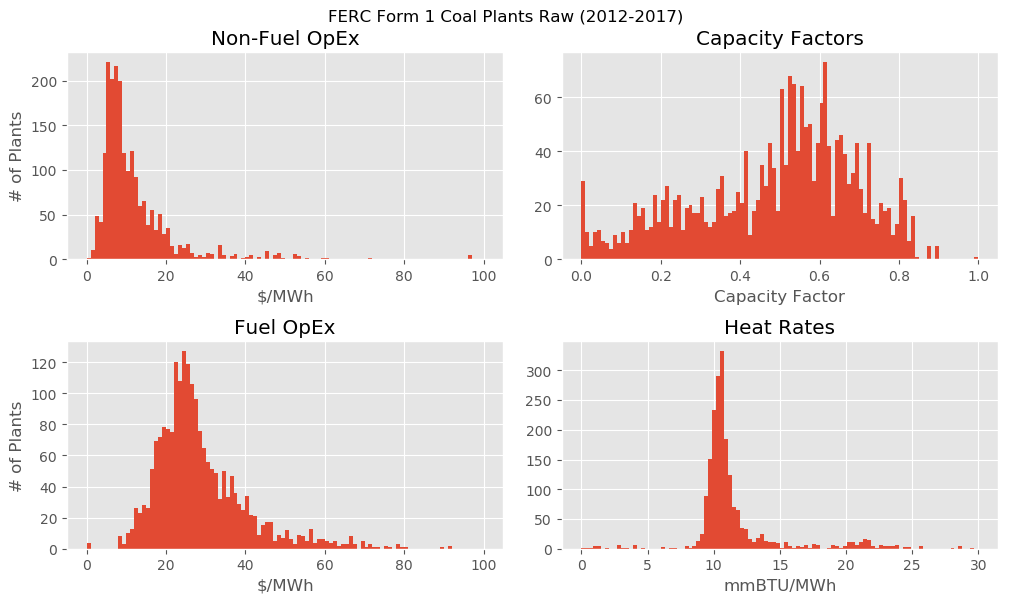

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=2, constrained_layout=True)

fig.suptitle('FERC Form 1 Coal Plants Raw (2012-2017)')

axs[0,0].hist(steam_agg_ferc1.opex_nonfuel_per_mwh, range=(0,100), bins=100);
axs[0,0].set_title('Non-Fuel OpEx')
axs[0,0].set_xlabel('$/MWh')
axs[0,0].set_ylabel('# of Plants')

axs[0,1].hist(steam_agg_ferc1.capacity_factor, range=(0,1), bins=100);
axs[0,1].set_title('Capacity Factors')
axs[0,1].set_xlabel('Capacity Factor')

axs[1,0].hist(steam_agg_ferc1.opex_fuel_per_mwh, range=(0,100), bins=100)
axs[1,0].set_title('Fuel OpEx')
axs[1,0].set_xlabel('$/MWh')
axs[1,0].set_ylabel('# of Plants')

axs[1,1].hist(steam_agg_ferc1.heat_rate_mmbtu_mwh, range=(0,30), bins=100)
axs[1,1].set_title('Heat Rates')
axs[1,1].set_xlabel('mmBTU/MWh')

plt.savefig('raw_ferc_hist.png')

plt.show();

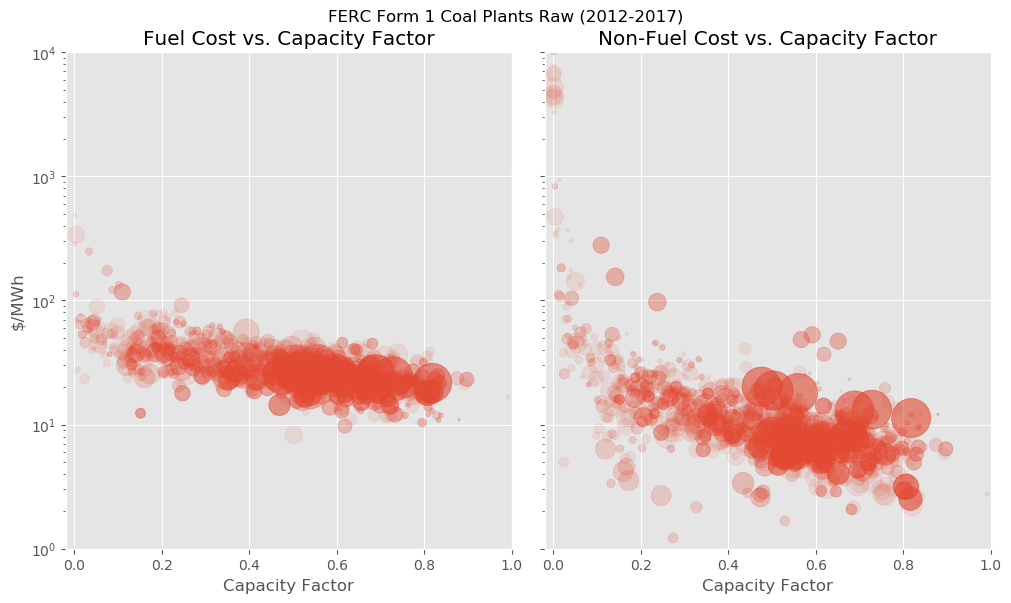

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=1, constrained_layout=True, sharey=True)
fig.suptitle('FERC Form 1 Coal Plants Raw (2012-2017)')

axs[0].scatter(steam_agg_ferc1.capacity_factor, steam_agg_ferc1.opex_fuel_per_mwh, s=steam_agg_ferc1.capacity_mw/10, alpha=0.1)
axs[0].set_yscale('log')
axs[0].set_xlabel('Capacity Factor')
axs[0].set_xlim(-0.02,1)
axs[0].set_ylabel('$/MWh')
axs[0].set_ylim(1e0,1e4)
axs[0].set_title('Fuel Cost vs. Capacity Factor')

axs[1].scatter(steam_agg_ferc1.capacity_factor, steam_agg_ferc1.opex_nonfuel_per_mwh, s=steam_agg_ferc1.capacity_mw/10, alpha=0.1)
axs[1].set_yscale('log')
axs[1].set_xlabel('Capacity Factor')
axs[1].set_xlim(-0.02,1)
axs[1].set_ylim(1e0,1e4)
axs[1].set_title('Non-Fuel Cost vs. Capacity Factor')

plt.savefig('mcoe_vs_capfac.png')

plt.show();

In [11]:
eia_cols_for_merge = [
    'report_date',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'state',
    'utility_id_eia',
    'utility_id_pudl',
    'utility_name',
    'latitude',
    'longitude',
    'balancing_authority_code',
    'iso_rto_code',
    'planned_retirement_date',
    'capacity_factor',
    'fuel_cost_per_mwh',
    'fuel_type_code_pudl',
    'heat_rate_mmbtu_mwh',
    'capacity_mw',
    #'net_generation_mwh',
    #'total_fuel_cost',
    #'fuel_cost_per_mmbtu',
    #'total_mmbtu',
]
eia_cols_for_out = [
    'report_date',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'state',
    'utility_id_eia',
    'utility_id_pudl',
    'utility_name',
    'capacity_factor',
    'fuel_cost_per_mwh',
    'fuel_type_code_pudl',
    'heat_rate_mmbtu_mwh',
    'capacity_mw',
    'net_generation_mwh',
    'total_fuel_cost',
    'fuel_cost_per_mmbtu',
    'total_mmbtu',
    'balancing_authority_code',
    'balancing_authority_name',
    'iso_rto_code',
    'latitude',
    'longitude',
    'planned_retirement_date',
]
ferc_cols = [
    'report_year',
    'plant_id_pudl',
    'utility_id_ferc1',
    'opex_fuel_per_mwh',
    'opex_nonfuel_per_mwh',
    'heat_rate_mmbtu_mwh',
    'capacity_factor',
    'capacity_mw',
    #'net_generation_mwh',
    #'opex_fuel',
    #'opex_nonfuel',
    #'fuel_consumed_mmbtu',
]

## Merging FERC & EIA together
* FERC is annual, EIA is monthly
* Before we kept EIA monthly b/c some years had bad (NA) months and aggregating to annual meant losing the whole year.
* This means that the merge has a *lot* of FERC data duplication
* Annual records are broadcast across all months of EIA
* PUDL Plant ID level aggregation is broadcast across all unit_id_pudl values in EIA
* Different sampling scales (both time and generation unit granularity) means only ratio are comparable
* Can compare cost / MWh but not absolute cost, heat rate but not fuel heat content.
* Need to figure out a way to plot this data for a single plant such that it's visually clear how well EIA & FERC values match
* Can do a scatter plot of the same values from both datasets (perfect match = diagonal line)
* Can plot the same values in both datasets against time on the x-axis

In [12]:
plant_ids_2017 = mcoe[(mcoe.report_date.dt.year==2017) &
                      (mcoe.fuel_type_code_pudl=='coal')].plant_id_pudl.unique()
mcoe_both = (
    # Keep only the relevant mcoe_cols
    mcoe.loc[:,eia_cols_for_merge].
    # Keep only record pertaining to plants that reported in 2017
    loc[(mcoe.plant_id_pudl.isin(plant_ids_2017)) &
        (mcoe.fuel_type_code_pudl=='coal'),:].
    drop(['fuel_type_code_pudl'], axis=1).
    # Create an EIA report year to merge on
    assign(report_year=lambda x: x['report_date'].dt.year).
    rename(columns={'fuel_cost_per_mwh':'opex_fuel_per_mwh'}).
    # Merge with FERC on year and plant_id_pudl
    merge(steam_agg_ferc1[ferc_cols], how='left', on=['report_year', 'plant_id_pudl'], suffixes=('_eia', '_ferc'))
)

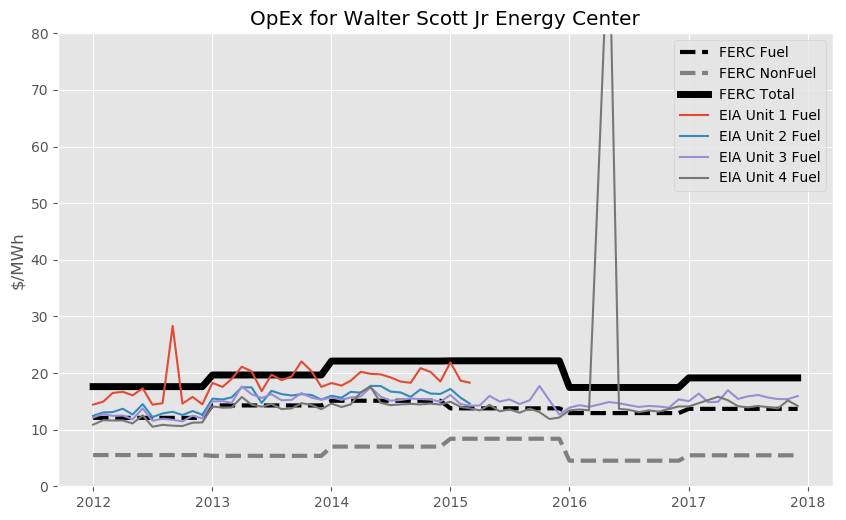

In [23]:
# choose a random plant:
pid=np.random.choice(mcoe_both.plant_id_pudl.unique())
mcoe_test = (
    mcoe_both.loc[mcoe_both.plant_id_pudl==pid,:].
    sort_values(['report_date', 'unit_id_pudl']).
    assign(opex_total_per_mwh_ferc=lambda x: x['opex_fuel_per_mwh_ferc'] +x['opex_nonfuel_per_mwh'])
)
plt.plot(mcoe_test.report_date, mcoe_test.opex_fuel_per_mwh_ferc, label="FERC Fuel", lw=3, color='black', ls='dashed')
plt.plot(mcoe_test.report_date, mcoe_test.opex_nonfuel_per_mwh, label="FERC NonFuel", lw=3, color='gray', ls='dashed')
plt.plot(mcoe_test.report_date, mcoe_test.opex_total_per_mwh_ferc, label="FERC Total", lw=5, color='black')

for unit_id in mcoe_test.unit_id_pudl.unique():
    mcoe_unit = mcoe_test[mcoe_test.unit_id_pudl==unit_id]
    plt.plot(mcoe_unit.report_date, mcoe_unit.opex_fuel_per_mwh_eia, label=f"EIA Unit {unit_id} Fuel")
    #plt.plot(mcoe_unit.report_date, mcoe_unit.capacity_factor_eia, label=f"EIA Unit {unit_id} Capacity Factor")
plant_name = mcoe_test.plant_name.unique()[0]
plt.title(f'OpEx for {plant_name}')
plt.ylabel("$/MWh")
plt.ylim(0,80)
plt.legend()
plt.show()
#mcoe_test

## Prepare for Excel Export

In [15]:
# So that we don't overwrite the same file repeatedly, give it a datestamp
import datetime
dtstr = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
#dtstr = 'test'
# Create XlsxWriter object for this spreadsheet:
ces_writer = pd.ExcelWriter('Coal_OPEX_{}.xlsx'.format(dtstr), engine='xlsxwriter')

In [16]:
# We're going to define annotations for several different sheets
summary_notes = {
    'report_year': "Four digit year, indicating year of FERC Form 1 Data.",
    'utility_id_ferc1': "FERC Respondent ID.",
    'utility_id_eia': "EIA Operator ID.",
    'utility_name': "FERC Respondent Name",
    'plant_id_pudl': "PUDL ID associated with this FERC Plant.",
    'report_date': 'Beginning date of the relevant reporting period, based on EIA 923.',
    'plant_id_eia': 'Plant ID, used across EIA data sources.',
    'unit_id_pudl': 'Generation unit ID, assigned during PUDL database initialization, for internal use. May not be stable.',
    'generator_id': 'Generation unit ID, as reported to EIA.',
    'plant_name': 'Plant name, as reported to EIA.',
    'utility_id_pudl': 'Utility ID, assigned during PUDL database initialization, for internal use. May not be stable.',
    'state': 'US State in which the power plant is located, as reported in EIA Form 860.',
    'latitude': 'Latitude of the power plant, as reported in EIA Form 860',
    'longitude': 'Longitude of the power plant, as reported in EIA Form 860',
    'iso_rto_code': 'Abbreviated name for ISO or RTO the plant serves, as reported on EIA Form 860. Not reported after 2012.',
    'balancing_authority_code': 'Abbreviated name for the load balancing authority served by the plant, as reported on EIA Form 860. Not reported before 2013.',
    #'fuel_type_pudl': 'Gross categorization of the primary fuel used by the generator. Assigned during PUDL database initialization.',
    'planned_retirement_date': 'Year and month of planned plant retirement, if it has been announced.',
    'capacity_mw_eia': 'Nameplate capacity of the generation unit, in MW, as reported to EIA in Form 860.',
    'capacity_mw_ferc': 'Nameplate capacity of the entire power plant (typically), in MW, as reported to FERC on Form 1.',
    'capacity_factor_eia': 'Calculated capacity factor for the generation unit, based on nameplate capacity and net generation reported to EIA.',
    'capacity_factor_ferc': 'Calculated capacity factor for the entire plant, based on nameplate capacity and net generation reported on FERC Form 1.',
    'heat_rate_mmbtu_mwh_eia': 'Calculated heat rate for the generation unit, in mmBTU/MWh. Based on fuel consumption reported per boiler, and generation reported per generation unit in EIA Form 923. Also depends on the boiler-generator associations inferred in PUDL.',
    'heat_rate_mmbtu_mwh_ferc': 'Calculated heat rate for the entire power plant, in mmBTU/MWh. Based on reported total fuel heat conetnt and net generation, as reported on FERC Form 1.',
    'opex_fuel_per_mwh_eia': 'Calculated fuel cost per MWh, based on fuel deliveries reported in EIA 923 within the specified reporting period, attributed per generator based on the associated boiler heat rate. Note that for solid fuels there may be a lag between delivery and consumption.',
    'opex_fuel_per_mwh_ferc':'Calculated fuel cost per MWh, based on total annual fuel costs and net generation at the plant level, as reported on FERC Form 1.',
    'opex_nonfuel_per_mwh':'Calculated non-fuel cost per MWh, based on the sum of all non-fuel expenses and net generation at the plant level, as reported on FERC Form 1.',
    #'total_cost_per_mwh_ferc':'Calculated total cost per MWh based on all plant level expenses and net generation reported on FERC Form 1.',
    #'total_cost_per_mwh_ferc_plus_eia':'Calculated total cost per MWh based on annual non-fuel plant level expenses reported on FERC Form 1, and per-reporting period, per-generation unit fuel costs calculated based on EIA data.'
}

summary_tags = {
    'data_source': {
        'report_date': 'eia923',
        'report_year': 'ferc1',
        'plant_id_eia': 'eia860, eia923',
        'plant_id_pudl': 'pudl',
        'unit_id_pudl': 'pudl',
        'generator_id': 'eia860',
        'plant_name': 'eia860',
        'utility_id_ferc1': 'ferc1',
        'utility_id_eia': 'eia860',
        'utility_id_pudl': 'pudl',
        'utility_name': 'eia860',
        'state': 'eia860',
        'latitude': 'eia860',
        'longitude': 'eia860',
        'iso_rto_code': 'eia860',
        'balancing_authority_code': 'eia860',
        #'fuel_type_pudl': 'pudl',
        'planned_retirement_date': 'eia860',
        'capacity_mw_eia': 'eia860',
        'capacity_mw_ferc': 'ferc1',
        'capacity_factor_eia': 'eia860, eia923',
        'capacity_factor_ferc': 'ferc1',
        'heat_rate_mmbtu_mwh_eia': 'eia860, eia923',
        'heat_rate_mmbtu_mwh_ferc': 'ferc1',
        'opex_fuel_per_mwh_eia': 'eia860, eia923',
        'opex_fuel_per_mwh_ferc': 'ferc1',
        'opex_nonfuel_per_mwh': 'ferc1',
        #'total_cost_per_mwh_ferc': 'ferc1',
        #'total_cost_per_mwh_ferc_plus_eia': 'ferc1, eia860, eia923'
    },
    'data_process': {
        'report_date': 'reported',
        'report_year': 'reported',
        'plant_id_eia': 'reported',
        'plant_id_pudl': 'assigned',
        'unit_id_pudl': 'assigned',
        'generator_id': 'reported',
        'plant_name': 'reported',
        'utility_id_ferc': 'reported',
        'utility_id_eia': 'reported',
        'utility_id_pudl': 'assigned',
        'utility_name': 'reported',
        'state': 'reported',
        'latitude': 'reported',
        'longitude': 'reported',
        'iso_rto_code': 'reported',
        'balancing_authority_code': 'reported',
        #'fuel_type_pudl': 'assigned',
        'planned_retirement_date': 'reported',
        'capacity_mw_eia': 'reported',
        'capacity_mw_ferc': 'reported',
        'capacity_factor_eia': 'calculated',
        'capacity_factor_ferc': 'calculated',
        'heat_rate_mmbtu_mwh_eia': 'calculated',
        'heat_rate_mmbtu_mwh_ferc': 'calculated',
        'opex_fuel_per_mwh_eia': 'calculated',
        'opex_fuel_per_mwh_ferc': 'calculated',
        'opex_nonfuel_per_mwh': 'calculated',
        #'total_cost_per_mwh_ferc': 'calculated',
        #'total_cost_per_mwh_ferc_plus_eia': 'calculated',
    }
}

ces_tmp = mcoe_both.sort_values(by=['plant_id_pudl','report_year'])
first_cols = [
    'report_date',
    'report_year',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'utility_id',
    'utility_id_pudl',
    'utility_name',
    'state',
    'latitude',
    'longitude',
    'iso_rto_code',
    'balancing_authority_code',
    #'fuel_type_pudl',
    'planned_retirement_date',
    'nameplate_capacity_mw_eia',
    'nameplate_capacity_mw_ferc',
]
ces_tmp = ces_tmp.reset_index()
ces_tmp = ces_tmp.drop('index', axis=1)
ces_tmp['report_date'] = ces_tmp.report_date.dt.date
ces_writer = pudl.output.export.annotated_xlsx(df=ces_tmp,
                                     notes_dict=summary_notes,
                                     tags_dict=summary_tags,
                                     sheet_name='summary',
                                     first_cols=first_cols,
                                     xlsx_writer=ces_writer)

In [17]:
eia_notes = {   
    'report_date': 'Beginning date of the relevant reporting period, based on EIA 923.',
    'report_year': 'Four digit year, inferred from report_date.',
    'plant_id_pudl': 'PUDL ID associated with this FERC Plant.',
    'plant_id_eia': 'Plant ID, used across EIA data sources.',
    'unit_id_pudl': 'Generation unit ID, assigned during PUDL database initialization, for internal use. May not be stable.',
    'generator_id': 'Generation unit ID, as reported to EIA.',
    'plant_name': 'Plant name, as reported to EIA.',
    'utility_id': "EIA Operator ID, as reported in EIA Form 860",
    'utility_name': "EIA Operator Name, as reported in EIA Form 860",
    'util_id_pudl': 'Utility ID, assigned during PUDL database initialization, for internal use. May not be stable.',
    'state': 'US State in which the power plant is located, as reported in EIA Form 860.',
    'latitude': 'Latitude of the power plant, as reported in EIA Form 860',
    'longitude': 'Longitude of the power plant, as reported in EIA Form 860',
    'iso_rto_code': 'Abbreviated name for ISO or RTO the plant serves, as reported on EIA Form 860. Not reported after 2012.',
    'balancing_authority_code': 'Abbreviated name for the load balancing authority served by the plant, as reported on EIA Form 860. Not reported before 2013.',
    'balancing_authority_name': 'Full name of the load balancing authority served by the plant, as reported on EIA Form 860. Not reported before 2013.',
    'capacity_mw': 'Nameplate capacity of the generation unit, in MW, as reported to EIA in Form 860.',
    'planned_retirement_date': 'Year and month of planned plant retirement, if it has been announced.',
    'capacity_factor': 'Calculated capacity factor for the generation unit, based on nameplate capacity and net generation reported to EIA.',
    'heat_rate_mmbtu_mwh': 'Calculated heat rate for the generation unit, in mmBTU/MWh. Based on fuel consumption reported per boiler, and generation reported per generation unit in EIA Form 923. Also depends on the boiler-generator associations inferred in PUDL.',
    'fuel_cost_per_mwh': 'Calculated fuel cost per MWh, based on fuel deliveries reported in EIA 923 within the specified reporting period, attributed per generator based on the associated boiler heat rate. Note that for solid fuels there may be a lag between delivery and consumption.',
    'net_generation_mwh': 'Net electricity generated by the generation unit, as reported in EIA Form 923 (per specified reporting period).',
    'total_mmbtu': 'Total heat content of fuel consumption attributed to this generator.',
    'total_fuel_cost': 'Total cost of all fuel attributed to the generator and delivered during the reporting period, as reported on EIA Form 923.',
}
eia_tags = {
    'data_source': {
        'report_date': 'eia923',
        'report_year': 'eia923',
        'plant_id_eia': 'eia860',
        'plant_id_pudl': 'pudl',
        'unit_id_pudl': 'pudl',
        'generator_id': 'eia860',
        'plant_name': 'eia860',
        'utility_id': 'eia860',
        'util_id_pudl': 'pudl',
        'utility_name': 'eia860',
        'state': 'eia860',
        'latitude': 'eia860',
        'longitude': 'eia860',
        'iso_rto_code': 'eia860',
        'balancing_authority_code': 'eia860',
        'balancing_authority_name': 'eia860',
        'fuel_type_pudl': 'pudl',
        'capacity_mw': 'eia860',
        'planned_retirement_date': 'eia860',
        'capacity_factor': 'eia860, eia923',
        'heat_rate_mmbtu_mwh': 'eia860, eia923',
        'fuel_cost_per_mwh': 'eia923',
        'net_generation_mwh': 'eia923',
        'total_mmbtu': 'eia923',
        'total_fuel_cost': 'eia923',
    },
    'data_process': {
        'report_date': 'reported',
        'report_year': 'calculated',
        'plant_id_eia': 'reported',
        'plant_id_pudl': 'assigned',
        'unit_id_pudl': 'assigned',
        'generator_id': 'reported',
        'plant_name': 'reported',
        'utility_id': 'reorted',
        'util_id_pudl': 'assigned',
        'utility_name': 'reported',
        'state': 'reported',
        'latitude': 'reported',
        'longitude': 'reported',
        'iso_rto_code': 'reported',
        'balancing_authority_code': 'reported',
        'balancing_authority_name': 'reported',
        'fuel_type_pudl': 'assigned',
        'capacity_mw': 'reported',
        'planned_retirement_date': 'reported',
        'capacity_factor': 'calculated',
        'heat_rate_mmbtu_mwh': 'calculated',
        'fuel_cost_per_mwh': 'calculated',
        'net_generation_mwh': 'calculated',
        'total_mmbtu': 'calculated',
        'total_fuel_cost': 'calculated'
    }
}
first_cols = [
    'report_date',
    'report_year',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'utility_id',
    'util_id_pudl',
    'utility_name',
    'state',
    'latitude',
    'longitude',
    'iso_rto_code',
    'balancing_authority_code',
    'balancing_authority_name',
    'fuel_type_pudl',
    'nameplate_capacity_mw',
    'planned_retirement_date',
]
#eia_out = eia_out.sort_values(by=['ces_label', 'report_date'])
eia_out = mcoe.sort_values(by=['plant_id_eia', 'report_date'])
eia_tmp = eia_out.reset_index()
eia_tmp = eia_tmp.drop('index', axis=1)
eia_tmp['report_date'] = eia_tmp.report_date.dt.date
ces_writer = pudl.output.export.annotated_xlsx(df=eia_tmp,
                                               notes_dict=eia_notes,
                                               tags_dict=eia_tags,
                                               sheet_name='eia_source_data',
                                               first_cols=first_cols,
                                               xlsx_writer=ces_writer)

In [18]:
# We need two dictionaires of annotations. One for notes, another for tags.
ferc_notes = {
    'report_year': "Four digit year, indicating year of FERC Form 1 Data.",
    'utility_id_ferc': "FERC Respondent ID.",
    'utility_name_ferc1': "FERC Respondent Name",
    'plant_id_pudl': "PUDL ID associated with this FERC Plant.",
    'plant_name': "Plant name as reported in FERC Form 1.",
    'installation_year': "Year of installation for earliest installed operating generator.",
    'avg_num_employees': "Average number of employees at the plant for the year. May be inaccurate due to partial ownership reporting.",
    'opex_boiler': "Expenses associated with boiler operations.",
    'opex_coolants': "Expenses associated with coolants.",
    'opex_electric': "The cost of electricity purchased for plant operations.",
    'opex_engineering': "Engineering expenses.",
    'opex_fuel': "Fuel expenses.",
    'opex_nonfuel': "The total of all expenses, except for fuel.",
    'total_mmbtu': "The total heat content in MMBTU of all fuel consumed by the plant in this year.",
    'opex_misc_power': "Miscellaneous power expenses",
    'opex_misc_steam': "Miscellaneous steam expenses",
    'opex_operations': "Operational expenses.",
    'opex_per_mwh': "Total expenses divided by total net generation of the plant.",
    'opex_plants': "Expenses for landscaping. Okay no, not really.",
    'opex_production_total': "Total of all production expenses, fuel and non-fuel.",
    'opex_rents': "Rents paid in the course of plant operations.",
    'opex_steam': "Expenses for purchased steam.",
    'opex_steam_other': "Other expenses associated with steam.",
    'opex_structures': "Expenses related to structural... stuff.",
    'opex_transfer': "Expenses transferred to or from this plant.",
    'net_generation_mwh': "Total net electricity generated by the plant in MWh.",
    'nameplate_capacity_mw': "Nameplate capacity of the power plant, reported to FERC."
}

ferc_tags = {
    'data_source': {
        'ces_label': 'ces',
        'ferc_label': 'ces',
        'report_year': 'ferc1',
        'utility_id_ferc': 'ferc1',
        'utility_name_ferc1': 'ferc1',
        'plant_id_pudl': 'pudl',
        'plant_name': 'ferc1',
        'installation_year': 'ferc1',
        'avg_num_employees': 'ferc1',
        'opex_boiler': 'ferc1',
        'opex_coolants': 'ferc1',
        'opex_electric': 'ferc1',
        'opex_engineering': 'ferc1',
        'opex_fuel': 'ferc1',
        'opex_nonfuel': 'ferc1',
        'total_mmbtu': 'ferc1',
        'opex_misc_power': 'ferc1',
        'opex_misc_steam': 'ferc1',
        'opex_operations': 'ferc1',
        'opex_per_mwh': 'ferc1',
        'opex_plants': 'ferc1',
        'opex_production_total': 'ferc1',
        'opex_rents': 'ferc1',
        'opex_steam': 'ferc1',
        'opex_steam_other': 'ferc1',
        'opex_structures': 'ferc1',
        'opex_transfer': 'ferc1',
        'net_generation_mwh': 'ferc1',
        'nameplate_capacity_mw': 'ferc1'
    },
     'data_process': {
        'report_year': 'reported',
        'utility_id_ferc': 'reported',
        'utility_name_ferc1': 'reported',
        'plant_id_pudl': 'assigned',
        'plant_name': 'reported',
        'installation_year': 'reported',
        'avg_num_employees': 'reported',
        'opex_boiler': 'reported',
        'opex_coolants': 'reported',
        'opex_electric': 'reported',
        'opex_engineering': 'reported',
        'opex_fuel': 'reported',
        'opex_nonfuel': 'calculated',
        'total_mmbtu': 'calculated',
        'opex_misc_power': 'reported',
        'opex_misc_steam': 'reported',
        'opex_operations': 'reported',
        'opex_per_mwh': 'reported',
        'opex_plants': 'reported',
        'opex_production_total': 'reported',
        'opex_rents': 'reported',
        'opex_steam': 'reported',
        'opex_steam_other': 'reported',
        'opex_structures': 'reported',
        'opex_transfer': 'reported',
        'net_generation_mwh': 'reported',
        'nameplate_capacity_mw': 'reported'
    }
}
first_cols = [
    'report_year',
    'plant_id_pudl',
    'plant_name',
    'utility_id_ferc',
    'utility_name_ferc',
    'nameplate_capacity_mw',
    'installation_year',
]
ferc_out = steam_agg_ferc1.sort_values(by=['plant_id_pudl','report_year'])
ferc_tmp = ferc_out.reset_index()
ferc_tmp = ferc_tmp.drop('index', axis=1)
ces_writer = pudl.output.export.annotated_xlsx(df=ferc_tmp,
                                               notes_dict=ferc_notes,
                                               tags_dict=ferc_tags,
                                               sheet_name='ferc_source_data',
                                               first_cols=first_cols,
                                               xlsx_writer=ces_writer)

In [19]:
ces_writer.save()